In [1]:
import pandas as pd 
import numpy as np
import random
import datetime
import sklearn.linear_model as skl_lm
import matplotlib.pyplot as plt 
import utilities as utils
import fractionalDiff as fd
import pickle
import scipy.stats as sps

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [7]:
overallScores = pd.read_csv('out_data/hour_2022-06-14.csv')
orders = overallScores.order.unique()
windows = overallScores.window.unique()
# iterations = overallScores.iteration.unique()


In [8]:
overallScores


,window,simulationDate,ticker,trainScore,testScore,alternativeMdlTestScore,strategyReturn,alternativeMdlStrategyReturn,assetReturn,order
0,2,2022-06-02 19:00:00,indicator,0,1.0,1.0,0.000828,0.000828,-0.002828,0.1
1,2,2022-06-02 21:00:00,indicator,0,0.0,0.0,-0.002626,-0.002626,-0.002626,0.1
2,2,2022-06-02 22:00:00,indicator,0,0.0,0.0,-0.005088,-0.005088,0.003088,0.1
3,2,2022-06-02 23:00:00,indicator,0,1.0,1.0,0.002806,0.002806,0.002806,0.1
4,2,2022-06-03 01:00:00,indicator,0,1.0,1.0,0.000678,0.000678,-0.002678,0.1
...,...,...,...,...,...,...,...,...,...,...
59185,24,2022-06-14 04:00:00,indicator,0,0.0,1.0,-0.027877,0.025877,0.025877,1.0
59186,24,2022-06-14 05:00:00,indicator,0,1.0,0.0,0.005783,-0.007783,-0.007783,1.0
59187,24,2022-06-14 06:00:00,indicator,0,0.0,0.0,-0.036008,-0.036008,0.034008,1.0
59188,24,2022-06-14 07:00:00,indicator,0,1.0,0.0,0.003987,-0.005987,-0.005987,1.0


In [11]:
groupByColumns = ['order', 'window']
outputColumns = groupByColumns + ['count', 'testScore', 'skew', 'kurt', 'testStd', 
    'strategyReturn', 'LRStd', 'alternativeMdlTestScore', 'amSkew', 'amKurt', 'amtestStd', 'alternativeMdlStrategyReturn', 'NNstd', 'assetReturn']

aggScores = overallScores.groupby(groupByColumns).agg({'testScore':[np.size, np.mean, sps.skew, sps.kurtosis, np.std], \
    'strategyReturn': [np.sum, np.std], 'alternativeMdlTestScore':[np.mean, sps.skew, sps.kurtosis, np.std], 'alternativeMdlStrategyReturn': [np.median, np.std], 'assetReturn':[np.sum]}).droplevel(level=[0], axis = 1).reset_index()
aggScores.columns = outputColumns

aggScores['nnUb'] = aggScores['NNstd'] + aggScores['alternativeMdlStrategyReturn']
aggScores['nnLb'] =+aggScores['alternativeMdlStrategyReturn'] - aggScores['NNstd']

aggScores['lrUb'] = aggScores['LRStd'] + aggScores['strategyReturn']
aggScores['lrLb'] = aggScores['strategyReturn'] - aggScores['LRStd']

aggScores.sort_values(by = ['strategyReturn'], ascending = False)

,order,window,count,testScore,skew,kurt,testStd,strategyReturn,LRStd,alternativeMdlTestScore,amSkew,amKurt,amtestStd,alternativeMdlStrategyReturn,NNstd,assetReturn,nnUb,nnLb,lrUb,lrLb
170,0.8,11,270,0.559259,-0.238720,-1.943013,0.497398,0.065960,0.008939,0.462963,0.148556,-1.977931,0.499552,-0.001447,0.008989,-0.571308,0.007542,-0.010436,0.074899,0.057021
49,0.3,5,260,0.511538,-0.046166,-1.997869,0.500831,0.038094,0.008254,0.457692,0.169840,-1.971154,0.499168,-0.001467,0.008302,-0.511793,0.006835,-0.009769,0.046348,0.029840
3,0.1,5,260,0.488462,0.046166,-1.997869,0.500831,0.028366,0.008259,0.457692,0.169840,-1.971154,0.499168,-0.001467,0.008302,-0.511793,0.006835,-0.009769,0.036625,0.020107
26,0.2,5,260,0.507692,-0.030773,-1.999053,0.500905,0.015716,0.008266,0.457692,0.169840,-1.971154,0.499168,-0.001467,0.008302,-0.511793,0.006835,-0.009769,0.023982,0.007450
7,0.1,9,271,0.549815,-0.200258,-1.959897,0.498433,0.010379,0.008950,0.464945,0.140567,-1.980241,0.499692,-0.001431,0.008974,-0.573575,0.007543,-0.010405,0.019330,0.001429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.9,22,259,0.486486,0.054074,-1.997076,0.500785,-0.297364,0.009135,0.459459,0.162698,-1.973529,0.499319,-0.001471,0.009104,-0.524027,0.007633,-0.010575,-0.288229,-0.306499
202,0.9,20,261,0.475096,0.099741,-1.990052,0.500339,-0.300719,0.009113,0.463602,0.145981,-1.978689,0.499631,-0.001463,0.009079,-0.535763,0.007616,-0.010542,-0.291606,-0.309832
153,0.7,17,264,0.469697,0.121435,-1.985253,0.500029,-0.301838,0.009111,0.465909,0.136682,-1.981318,0.499784,-0.001410,0.009071,-0.559298,0.007661,-0.010481,-0.292726,-0.310949
175,0.8,16,265,0.464151,0.143766,-1.979331,0.499657,-0.319045,0.009094,0.464151,0.143766,-1.979331,0.499657,-0.001431,0.009056,-0.557641,0.007626,-0.010487,-0.309951,-0.328140


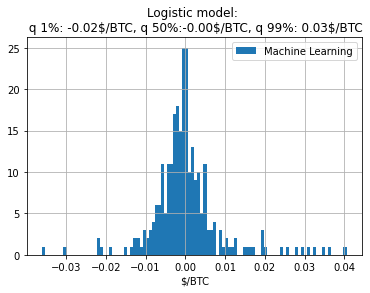

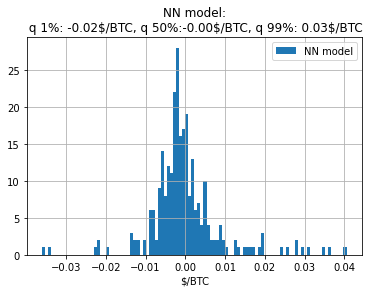

In [14]:
stats = overallScores.loc[(overallScores.order == orders[7]) & (overallScores.window == 11)]
stats.strategyReturn.hist(bins = 100)
plt.title(f'Logistic model: \n q 1%: {np.quantile(stats.strategyReturn, 0.01):.2f}$/BTC, q 50%:{stats.strategyReturn.median():.2f}$/BTC, q 99%: {np.quantile(stats.strategyReturn, 0.99):.2f}$/BTC')
plt.xlabel('$/BTC')
plt.legend(['Machine Learning'])
plt.show()
stats.alternativeMdlStrategyReturn.hist(bins = 100)
plt.title(f'NN model:\n q 1%: {np.quantile(stats.alternativeMdlStrategyReturn, 0.01):.2f}$/BTC, q 50%:{stats.alternativeMdlStrategyReturn.median():.2f}$/BTC, q 99%: {np.quantile(stats.alternativeMdlStrategyReturn, 0.99):.2f}$/BTC')
plt.xlabel('$/BTC')
plt.legend(['NN model'])
plt.show()

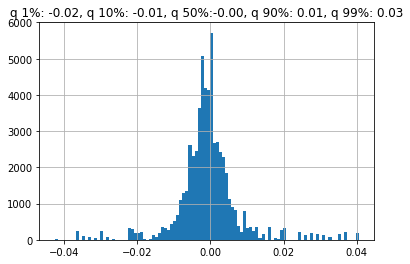

In [16]:
overallScores.strategyReturn.hist(bins = 100)
plt.title(f'q 1%: {np.quantile(overallScores.alternativeMdlStrategyReturn, 0.01):.2f}, q 10%: {np.quantile(overallScores.alternativeMdlStrategyReturn, 0.1):.2f}, q 50%:{overallScores.alternativeMdlStrategyReturn.median():.2f}, q 90%: {np.quantile(overallScores.alternativeMdlStrategyReturn, 0.9):.2f}, q 99%: {np.quantile(overallScores.alternativeMdlStrategyReturn, 0.99):.2f}')
plt.show()

In [9]:
aggScores.columns

Index(['order', 'window', 'count', 'testScore', 'skew', 'kurt', 'testStd',
       'strategyReturn', 'LRStd', 'alternativeMdlTestScore', 'amSkew',
       'amKurt', 'amtestStd', 'alternativeMdlStrategyReturn', 'NNstd',
       'assetReturn', 'NNPercentError', 'LRPercentError'],
      dtype='object')

In [380]:
aggScores

,order,window,count,testScore,skew,kurt,testStd,strategyReturn,LRStd,alternativeMdlTestScore,amSkew,amKurt,amtestStd,alternativeMdlStrategyReturn,NNstd,assetReturn,NNPercentError,LRPercentError
0,0.1,3,74,0.495495,-0.052366,-0.277662,0.092418,200.645,36.857465,0.507320,0.350344,-0.477549,0.081998,55.870,34.015327,-7.125,60.882991,18.369491
1,0.1,4,83,0.498996,-0.198231,-0.644296,0.087540,363.765,30.576304,0.523092,-0.434271,-0.357746,0.078695,668.885,29.252454,55.035,4.373316,8.405510
2,0.1,5,84,0.496032,-0.161780,-0.453380,0.089533,88.910,29.620340,0.525794,0.098079,-0.498938,0.078926,796.720,28.014886,68.430,3.516277,33.314971
3,0.1,6,84,0.494048,0.010875,-0.360690,0.089655,36.160,30.317879,0.516865,-0.092600,-0.467441,0.067564,548.340,28.237439,78.945,5.149622,83.843692
4,0.1,7,84,0.493552,-0.033524,-0.550795,0.086895,192.855,30.574528,0.515873,0.017423,-0.923639,0.078394,420.440,29.399667,110.390,6.992595,15.853635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1.0,6,84,0.513393,0.110123,-0.366527,0.094874,836.745,35.740308,0.513393,-0.329663,0.138832,0.084866,967.200,36.016440,78.945,3.723784,4.271350
76,1.0,7,84,0.515873,0.062579,-0.061553,0.090066,959.965,37.461441,0.519345,-0.315216,0.432798,0.093605,961.450,36.383083,110.390,3.784189,3.902376
77,1.0,8,83,0.515060,0.170247,-0.076348,0.088646,769.820,35.008740,0.505020,0.094980,-0.454571,0.087400,819.425,34.787624,116.155,4.245370,4.547653
78,1.0,9,82,0.521341,0.457860,-0.218129,0.093340,868.220,37.736453,0.512195,-0.251567,0.091091,0.097659,880.210,38.506015,121.920,4.374640,4.346416


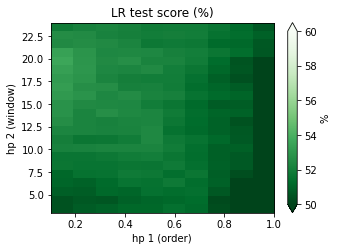

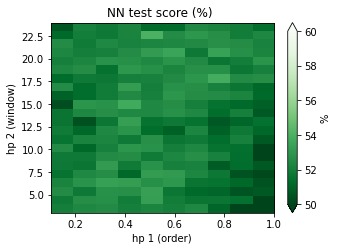

In [35]:
extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)
iterations = [0]
ZLR = 100. * aggScores.pivot('window', 'order', 'testScore').values
ZNN = 100. *aggScores.pivot('window', 'order', 'alternativeMdlTestScore').values

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZLR, cmap = mpl.cm.Greens_r, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(50, 60)
plt.title("LR test score (%)")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/LRtestScore.jpeg", dpi=150)

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZNN, cmap = mpl.cm.Greens_r, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(50, 60)
plt.title("NN test score (%) ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/NNtestScore.jpeg", dpi=150)

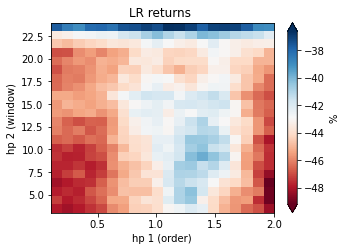

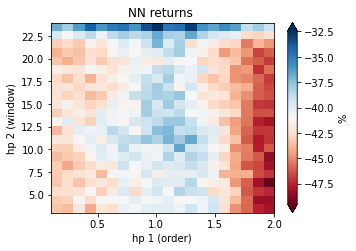

In [96]:
extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)


ZNN = 100.*aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZLR = 100.*aggScores.pivot('window', 'order', 'strategyReturn').values

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZLR, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(100.*np.min(aggScores.strategyReturn.values), 100.*np.max(aggScores.strategyReturn.values))
plt.title("LR returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_wf_lr_negativeOrders.jpeg", dpi=250)

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(100.*np.min(aggScores.alternativeMdlStrategyReturn.values), 100.*np.max(aggScores.alternativeMdlStrategyReturn.values))
plt.title("NN returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_wf_nn_negativeOrders_day.jpeg", dpi=250)


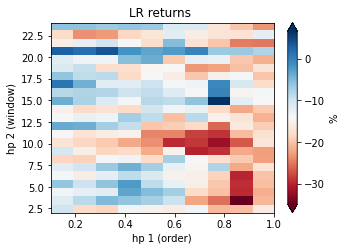

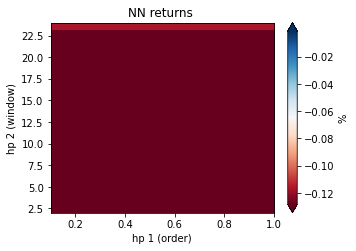

In [20]:
extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)


ZNN = 100*aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZLR = 100*aggScores.pivot('window', 'order', 'strategyReturn').values

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZLR, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(100*np.min(aggScores.strategyReturn.values), 100*np.max(aggScores.strategyReturn.values))
plt.title("LR returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_wf_lr_negativeOrders.jpeg", dpi=150)

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(np.min(aggScores.alternativeMdlStrategyReturn.values), np.max(aggScores.alternativeMdlStrategyReturn.values))
plt.title("NN returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_wf_nn_negativeOrders.jpeg", dpi=150)

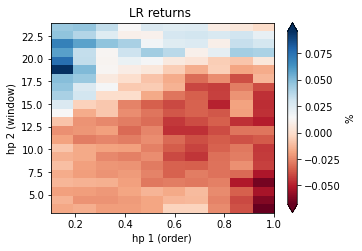

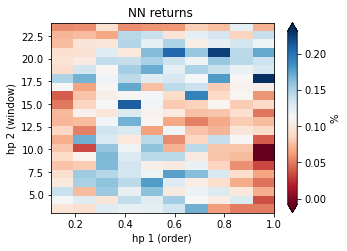

In [42]:
extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)


ZNN = aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZLR = aggScores.pivot('window', 'order', 'strategyReturn').values

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZLR, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("LR returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_wf_lr.jpeg", dpi=150)

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(np.min(aggScores.alternativeMdlStrategyReturn.values), np.max(aggScores.alternativeMdlStrategyReturn.values))
plt.title("NN returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_wf_nn.jpeg", dpi=150)

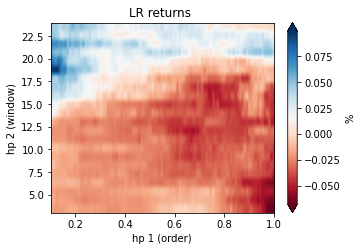

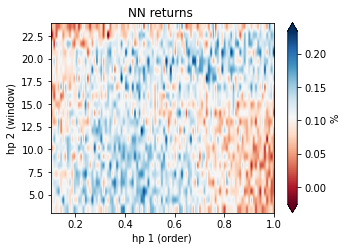

In [47]:
extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)


ZNN = aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZLR = aggScores.pivot('window', 'order', 'strategyReturn').values

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZLR, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("LR returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_wf_lr.jpeg", dpi=150)

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(np.min(aggScores.alternativeMdlStrategyReturn.values), np.max(aggScores.alternativeMdlStrategyReturn.values))
plt.title("NN returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_wf_nn.jpeg", dpi=150)

In [324]:
aggScoresPre.pivot('window', 'order', 'strategyReturn')

order,0.500,0.625,0.750,0.875,1.000
window,,,,,
8,4223.68,734.64,-1458.84,-208.46,2755.26
9,3013.42,1349.52,-1896.74,-2577.68,-3445.94
10,-639.08,1999.42,-6425.28,-5382.68,-5177.02


In [328]:
aggScoresPre.pivot('window', 'order', 'LRPercentError')

order,0.500,0.625,0.750,0.875,1.000
window,,,,,
8,9.241550,53.173231,26.775002,187.393446,14.173263
9,12.976754,28.985863,20.621657,15.172029,11.346560
10,61.317093,19.595817,6.087701,7.270855,7.560426


In [329]:
aggScores.pivot('window', 'order', 'strategyReturn')

order,0.500,0.625,0.750,0.875,1.000
window,,,,,
8,958.92,2198.80,2252.26,2375.54,4127.22
9,2154.30,3672.10,560.64,1543.94,1986.40
10,1908.64,1619.22,1392.60,1197.18,2126.02


In [330]:
aggScores.pivot('window', 'order', 'LRPercentError')

order,0.500,0.625,0.750,0.875,1.000
window,,,,,
8,20.237555,8.784496,8.573529,8.123011,4.610732
9,9.001758,5.223864,34.771647,12.594861,9.770889
10,10.221536,12.063614,14.038452,16.340089,9.166535


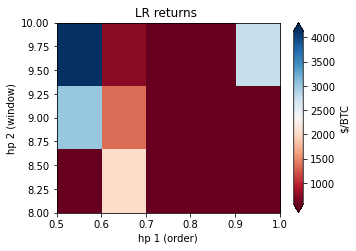

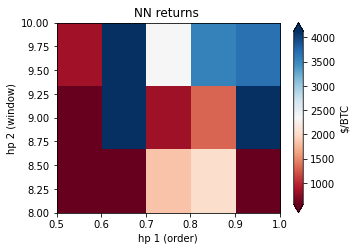

In [320]:
extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)


ZNN = aggScoresPre.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZLR = aggScoresPre.pivot('window', 'order', 'strategyReturn').values

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZLR, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('$/BTC')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("LR returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_pre_lr.jpeg", dpi=150)

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('$/BTC')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("NN returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_pre_nn.jpeg", dpi=150)


Text(0, 0.5, 'hp 2 (window)')

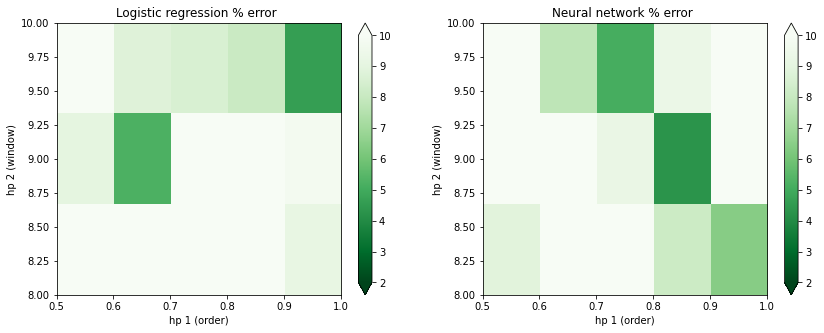

In [325]:
plt.figure(figsize=(14, 5))

extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)
ZLR = aggScores.pivot('window', 'order', 'LRPercentError').values
ZNN = aggScores.pivot('window', 'order', 'NNPercentError').values

plt.subplot(1, 2, 1)
plt.imshow(ZLR, cmap = mpl.cm.Greens_r, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(2, 10)
plt.title("Logistic regression % error ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

plt.subplot(1, 2, 2)
plt.imshow(ZNN, cmap = mpl.cm.Greens_r, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(2, 10)
plt.title("Neural network % error ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

Text(0, 0.5, 'hp 2 (window)')

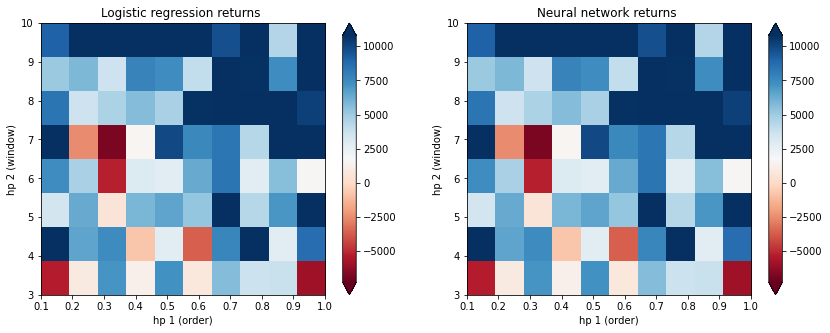

In [258]:
plt.figure(figsize=(14, 5))

extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)
ZLR = aggScores.pivot('window', 'order', 'strategyReturn').values
ZNN = aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZNN2 = aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZAsset = aggScores.pivot('window', 'order', 'assetReturn').values

plt.subplot(1, 2, 1)
plt.imshow(ZNN2, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("Logistic regression returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

plt.subplot(1, 2, 2)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("Neural network returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

Text(0, 0.5, 'hp 2 (window)')

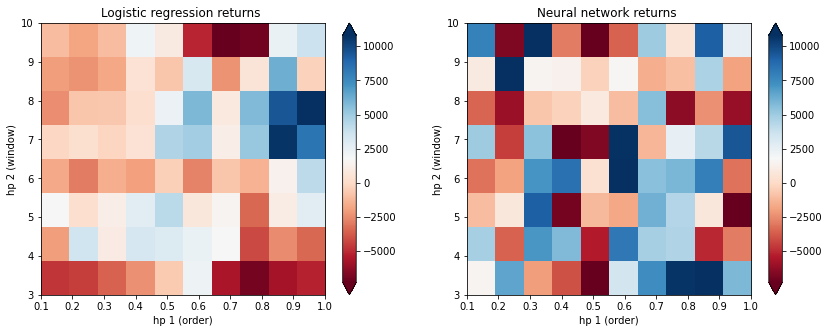

In [229]:
plt.figure(figsize=(14, 5))

extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)
ZLR = aggScores.pivot('window', 'order', 'strategyReturn').values
ZNN = aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZAsset = aggScores.pivot('window', 'order', 'assetReturn').values

plt.subplot(1, 2, 1)
plt.imshow(ZLR, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("Logistic regression returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

plt.subplot(1, 2, 2)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("Neural network returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

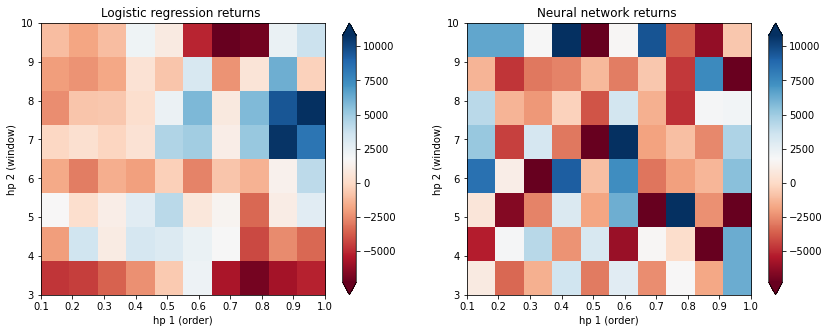

In [224]:
plt.figure(figsize=(14, 5))

extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)
ZLR = aggScores.pivot('window', 'order', 'strategyReturn').values
ZNN = aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZAsset = aggScores.pivot('window', 'order', 'assetReturn').values

plt.subplot(1, 2, 1)
plt.imshow(ZLR, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("Logistic regression returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

plt.subplot(1, 2, 2)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("Neural network returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

plt.savefig("imgs/pError.jpeg", dpi=150)

In [ ]:
firstOrderDifferences.close.hist(bins = 50)
plt.title(f'q 10%: {np.quantile(firstOrderDifferences.close, 0.1):.2f}, q 50%:{firstOrderDifferences.close.median():.2f}, q 90%: {np.quantile(firstOrderDifferences.close, 0.9):.2f}') 
plt.show()

In [10]:
scoresToPlot = aggScores.groupby(['order']).agg({'alternativeMdlTestScore':np.median, 'alternativeMdlStrategyReturn': np.median, 'testScore':np.median, 'strategyReturn':np.median}).reset_index()
scoresToPlot

,order,alternativeMdlTestScore,alternativeMdlStrategyReturn,testScore,strategyReturn
0,0.1,0.517498,0.018263,0.508877,-0.008846
1,0.2,0.514453,0.019008,0.507879,-0.011045
2,0.3,0.512103,0.018873,0.509113,-0.010469
3,0.4,0.516616,0.021380,0.509952,-0.009347
4,0.5,0.516240,0.022151,0.511457,-0.006987
5,0.6,0.516359,0.019560,0.510584,-0.005657
6,0.7,0.516689,0.020039,0.510016,-0.003694
7,0.8,0.516959,0.024801,0.509674,-0.004985
8,0.9,0.514814,0.025748,0.511512,-0.001203
9,1.0,0.510664,0.011583,0.508691,0.000146


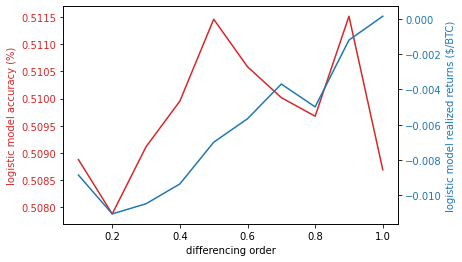

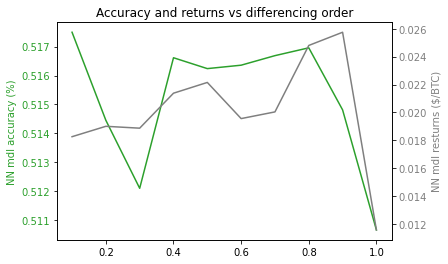

In [11]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('differencing order')
ax1.set_ylabel('logistic model accuracy (%)', color=color)
ax1.plot(scoresToPlot.order, scoresToPlot.testScore, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('logistic model realized returns ($/BTC)', color=color)  # we already handled the x-label with ax1
ax2.plot(scoresToPlot.order, scoresToPlot.strategyReturn, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()

fig2, ax3 = plt.subplots()

color = 'tab:green'
ax3.set_ylabel('NN mdl accuracy (%)', color=color) 
ax3.plot(scoresToPlot.order, scoresToPlot.alternativeMdlTestScore, color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()
color = 'tab:grey'
ax4.set_ylabel('NN mdl resturns ($/BTC)', color=color) 
ax4.plot(scoresToPlot.order, scoresToPlot.alternativeMdlStrategyReturn, color=color)
ax4.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'Accuracy and returns vs differencing order')
plt.show()

In [69]:
strategyToPLot

,window,simulationDate,ticker,trainScore,testScore,alternativeMdlTestScore,strategyReturn,alternativeMdlStrategyReturn,assetReturn,order
20120,7,2022-05-03 14:00:00,indicator,0,0.0,1.0,-58.97,58.97,58.97,1.0
20121,7,2022-05-03 15:00:00,indicator,0,0.0,0.0,-183.98,-183.98,-183.98,1.0
20122,7,2022-05-03 16:00:00,indicator,0,1.0,0.0,105.88,-105.88,-105.88,1.0
20123,7,2022-05-03 17:00:00,indicator,0,1.0,1.0,277.82,277.82,-277.82,1.0
20124,7,2022-05-03 18:00:00,indicator,0,1.0,1.0,49.05,49.05,-49.05,1.0
...,...,...,...,...,...,...,...,...,...,...
20389,7,2022-05-14 19:00:00,indicator,0,0.0,0.0,-40.40,-40.40,40.40,1.0
20390,7,2022-05-14 20:00:00,indicator,0,1.0,0.0,321.35,-321.35,321.35,1.0
20391,7,2022-05-14 21:00:00,indicator,0,1.0,1.0,525.66,525.66,525.66,1.0
20392,7,2022-05-14 22:00:00,indicator,0,1.0,1.0,147.97,147.97,-147.97,1.0


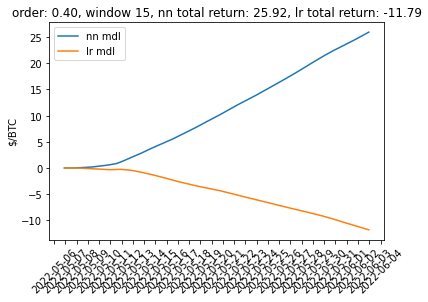

In [12]:
#for window in windows:
window = 15
#xy = scoresToPlot.loc[scoresToPlot.window == window]
for order in [orders[3]]:
    #order = orders[7]
    strategyToPLot = overallScores.loc[(overallScores.window == window) & (overallScores.order == order)]
    dates = []
    for row in strategyToPLot.simulationDate:
        dates.append(mpl.dates.date2num(datetime.datetime.strptime(row, '%Y-%m-%d %H:%M:%S')))
    #strategyToPLotTF = overallScoresTrendFollow.loc[(overallScoresTrendFollow.window == window) & (overallScoresTrendFollow.order == order)]
    fig, ax = plt.subplots()
    ax.plot(dates, strategyToPLot.alternativeMdlStrategyReturn.cumsum())
    ax.plot(dates, strategyToPLot.strategyReturn.cumsum())
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    #plt.plot(strategyToPLotTF.simulationDate, strategyToPLotTF.alternativeMdlStrategyReturn.cumsum())
    #plt.plot(scoresToPlot.order, scoresToPlot.realizedReturn)
    plt.title(f'order: {order:.2f}, window {window}, nn total return: {strategyToPLot.alternativeMdlStrategyReturn.sum():.2f}, lr total return: {strategyToPLot.strategyReturn.sum():.2f}')
    plt.xticks(rotation = 45)
    ax.xaxis.set_major_locator(mpl.dates.DayLocator())
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m-%d'))
    ax.legend(['nn mdl', 'lr mdl'])
    plt.ylabel('$/BTC')
    plt.show()